In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [113]:
data=pd.read_csv("/content/drive/MyDrive/Main Project/Models/Multiple site.csv")
data.head()

,SiteId,Timestamp,Value,Temperature,Holiday
0,40,2017-01-11T04:30:00+00:00,10879.083336,-4.0,1
1,40,2017-01-11T04:30:00+00:00,10879.083336,-4.0,1
2,40,2017-01-11T04:30:00+00:00,10879.083336,-4.0,1
3,40,2017-01-11T04:30:00+00:00,10879.083336,-4.0,1
4,40,2017-01-11T04:30:00+00:00,10879.083336,-4.0,1


In [114]:
site_ids=data['SiteId'].unique()
site_ids

array([40,  8,  9, 25, 26, 46, 48, 49, 50, 51, 10, 12, 23, 44, 19,  6,  7,
       16,  2,  3,  5, 20, 33, 29, 32, 38, 22, 41, 13])

SiteId - 40

In [115]:
data_site40=data[data['SiteId']==40]
data_site40['Timestamp'] = pd.to_datetime(data_site40['Timestamp'])

# Set the 'Timestamp' as the index
data_site40.set_index('Timestamp', inplace=True)

# Resample the data to daily frequency and aggregate the 'Value' column
daily_df_40 = data_site40.groupby('SiteId').resample('D').median()
daily_df_40.drop(columns=['SiteId'],inplace=True)
daily_df_40.reset_index(inplace=True)
daily_df_40.drop(columns=['SiteId'],inplace=True)
daily_df_40['Month'] = daily_df_40['Timestamp'].dt.month
daily_df_40=daily_df_40.rename(columns={'Temperature':'temp','Month':'month','Value':'y','Timestamp':'ds'})
daily_df_40.head()


<ipython-input-115-a05ae190850f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_site40['Timestamp'] = pd.to_datetime(data_site40['Timestamp'])


,ds,y,temp,Holiday,month
0,2015-07-03 00:00:00+00:00,5492.135061,31.0,1.0,7
1,2015-07-04 00:00:00+00:00,545.152921,27.5,1.0,7
2,2015-07-05 00:00:00+00:00,543.557177,28.0,1.0,7
3,2015-07-06 00:00:00+00:00,6180.235526,27.5,1.0,7
4,2015-07-07 00:00:00+00:00,6009.339107,28.0,1.0,7


In [116]:
daily_df_40[['month','temp']].groupby('month').agg({'temp':{'max','min','mean'}})

temp                 
        max   min       mean
month                       
1       9.0  -4.0   1.862903
2      13.0   2.0   5.763158
3      13.0   1.0   7.693548
4      16.0   6.0  10.700000
5      23.5   7.0  14.604839
6      27.5  13.0  19.600000
7      31.0  13.0  21.934066
8      27.5  13.0  20.322581
9      22.0   8.0  15.300000
10     16.0   5.5  10.586022
11     13.0  -1.0   6.605263
12      8.0  -3.0   1.669355

In [117]:
daily_df_40[['y','temp']].corr()

,y,temp
y,1.000000,-0.465369
temp,-0.465369,1.000000


In [118]:
def summer_temp(temp):
  if temp > 20:
    return 1
  else:
    return 0

In [119]:
daily_df_40['summer_temp']=daily_df_40['temp'].apply(summer_temp)

daily_df_40['month_bins']=pd.cut(daily_df_40['month'],bins=3, labels=False)
daily_df_40.head()

,ds,y,temp,Holiday,month,summer_temp,month_bins
0,2015-07-03 00:00:00+00:00,5492.135061,31.0,1.0,7,1,1
1,2015-07-04 00:00:00+00:00,545.152921,27.5,1.0,7,1,1
2,2015-07-05 00:00:00+00:00,543.557177,28.0,1.0,7,1,1
3,2015-07-06 00:00:00+00:00,6180.235526,27.5,1.0,7,1,1
4,2015-07-07 00:00:00+00:00,6009.339107,28.0,1.0,7,1,1


In [120]:
train = daily_df_40[(daily_df_40['ds'] >= '2013-03-21') & (daily_df_40['ds'] <= '2016-08-01')]
test = daily_df_40[daily_df_40['ds'] > '2016-08-01']

In [121]:
print("Shape of train data:",train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (396, 7)
Shape of test data: (472, 7)


Prophet Model

In [122]:
m=Prophet(interval_width=0.95,yearly_seasonality=True)
m.add_regressor('summer_temp',standardize=False)
m.add_regressor('month_bins',standardize=False,mode='multiplicative')
m.add_regressor('Holiday', standardize=False)
# Remove timezone information from the 'ds' column in the 'train' DataFrame
train['ds'] = train['ds'].dt.tz_localize(None)

# Now try fitting the model again
m.fit(train)
future = m.make_future_dataframe(periods=len(test), include_history=True)
future.tail()

<ipython-input-122-7f020fbe451e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = train['ds'].dt.tz_localize(None)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplfkxnhnp/h51p29sd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplfkxnhnp/ji3qtnym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9931', 'data', 'file=/tmp/tmplfkxnhnp/h51p29sd.json', 'init=/tmp/tmplfkxnhnp/ji3qtnym.json', 'output', 'file=/tmp/tmplfkxnhnp/prophet_model5v510dsd/prophet_model-20240819181248.csv', 'method=optimize',

,ds
863,2017-11-12
864,2017-11-13
865,2017-11-14
866,2017-11-15
867,2017-11-16


In [123]:
future['summer_temp'] = pd.concat([train['summer_temp'], test['summer_temp']], axis=0)
future['month_bins'] = pd.concat([train['month_bins'], test['month_bins']], axis=0)
future['Holiday'] = pd.concat([train['Holiday'], test['Holiday']], axis=0)
future

,ds,summer_temp,month_bins,Holiday
0,2015-07-03,1,1,1.0
1,2015-07-04,1,1,1.0
2,2015-07-05,1,1,1.0
3,2015-07-06,1,1,1.0
4,2015-07-07,1,1,1.0
...,...,...,...,...
863,2017-11-12,0,2,1.0
864,2017-11-13,0,2,1.0
865,2017-11-14,0,2,1.0
866,2017-11-15,0,2,1.0


In [124]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
863,2017-11-12,3758.477748,952.561168,6814.042244
864,2017-11-13,8673.591878,5688.934214,11830.741824
865,2017-11-14,8711.885445,5711.509568,11896.573682
866,2017-11-15,8636.371850,5301.980928,11522.604007
867,2017-11-16,8696.973339,5678.117751,11689.744284


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


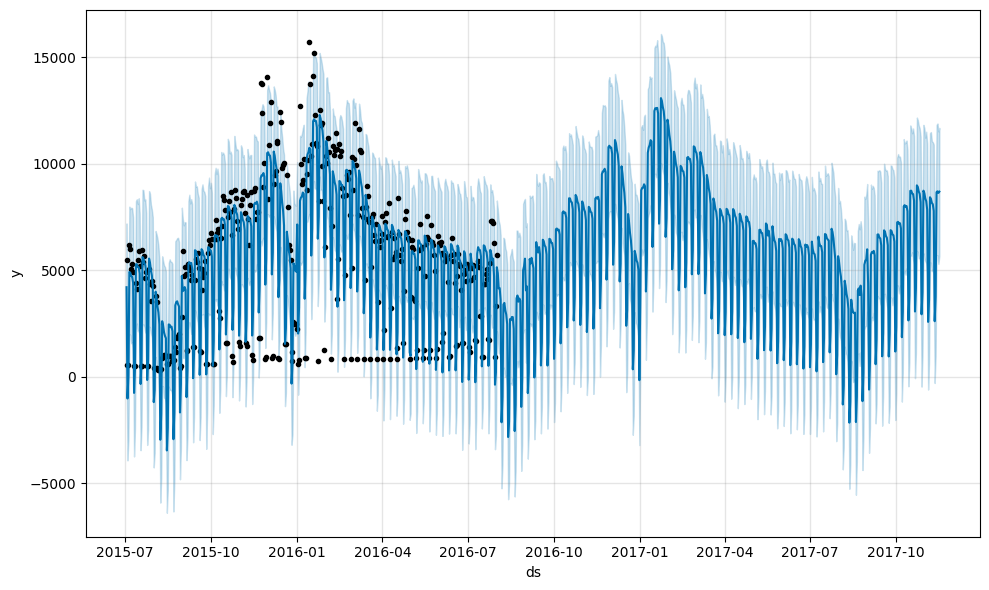

In [125]:
## Ploting actual value and predicated value
f1=m.plot(forecast)

In [126]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model=m,initial = '270 days', horizon = '125 days')
df_p=performance_metrics(df_cv)
df_p

INFO:prophet:Making 1 forecasts with cutoffs between 2016-03-29 00:00:00 and 2016-03-29 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplfkxnhnp/403fgdar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplfkxnhnp/q67oqd3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33040', 'data', 'file=/tmp/tmplfkxnhnp/403fgdar.json', 'init=/tmp/tmplfkxnhnp/q67oqd3t.json', 'output', 'file=/tmp/tmplfkxnhnp/prophet_model1e0xgwbs/prophet_model-20240819181249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,9.645286e+06,3105.686138,2813.484720,1.000741,0.442717,0.972925,0.750000
1,13 days,1.056711e+07,3250.708669,3048.702769,1.034983,0.472023,1.020478,0.750000
2,14 days,1.091146e+07,3303.249162,3151.854712,1.056527,0.472023,1.049966,0.750000
3,15 days,1.135852e+07,3370.239752,3225.186247,1.072190,0.515142,1.075817,0.666667
4,16 days,1.157644e+07,3402.417413,3275.075460,0.925895,0.472023,0.955708,0.666667
...,...,...,...,...,...,...,...,...
109,121 days,2.115231e+06,1454.383289,1325.832136,0.402285,0.316773,0.317999,1.000000
110,122 days,2.054427e+06,1433.327403,1302.608383,0.288603,0.270525,0.262345,1.000000
111,123 days,1.632413e+06,1277.659324,1169.322584,0.314959,0.270525,0.352488,1.000000
112,124 days,2.026249e+06,1423.463894,1242.468781,0.350723,0.270525,0.467722,1.000000


SiteId - 9

In [127]:
# # Filter data for SiteId 9 and convert 'Timestamp' to datetime
# data_site9 = data[data['SiteId'] == 9]
# data_site9['Timestamp'] = pd.to_datetime(data_site9['Timestamp'])

# data_site9.set_index('Timestamp', inplace=True)

# data_site_9 = data_site9.resample('D').median()

# data_site_9.reset_index(inplace=True)
# data_site_9['Month'] = data_site_9['Timestamp'].dt.month
# data_site_9 = data_site_9.rename(columns={'Temperature': 'temp', 'Month': 'month', 'Value': 'y', 'Timestamp': 'ds'})

# # Drop any NaN values
# data_site_9.dropna(inplace=True)

# # Group by 'month' and calculate summary statistics for 'temp'
# print(data_site_9.groupby('month')['temp'].agg(['max', 'min', 'mean']))

# # Calculate correlation between 'y' and 'temp'
# print(data_site_9[['y', 'temp']].corr())

# # Function to classify temperature as 'summer_temp'
# def summer_temp(temp):
#     return 1 if temp > 20 else 0

# data_site_9['summer_temp'] = data_site_9['temp'].apply(summer_temp)

# # Create bins for 'month' and label them
# data_site_9['month_bins'] = pd.cut(data_site_9['month'], bins=3, labels=False)

# # Split data into training and testing sets
# train = data_site_9[(data_site_9['ds'] >= '2013-03-21') & (data_site_9['ds'] <= '2016-08-01')]
# test = data_site_9[data_site_9['ds'] > '2016-08-01']

# print("Shape of train data:", train.shape)
# print("Shape of test data:", test.shape)

# # Initialize the Prophet model with yearly seasonality
# m = Prophet(interval_width=0.95, yearly_seasonality=True)
# m.add_regressor('summer_temp', standardize=False)
# m.add_regressor('month_bins', standardize=False, mode='multiplicative')
# m.add_regressor('Holiday', standardize=False)

# # Remove timezone information from 'ds' column
# train['ds'] = train['ds'].dt.tz_localize(None)

# m.fit(train)

# # Create future dataframe and prepare it for prediction
# future = m.make_future_dataframe(periods=len(test), include_history=True)

# # Ensure that 'future' has the same index as 'train' and 'test'
# future = future.set_index('ds')

# future['summer_temp'] = pd.concat([train.set_index('ds')['summer_temp'], test.set_index('ds')['summer_temp']]).reindex(future.index)
# future['month_bins'] = pd.concat([train.set_index('ds')['month_bins'], test.set_index('ds')['month_bins']]).reindex(future.index)
# future['Holiday'] = pd.concat([train.set_index('ds')['Holiday'], test.set_index('ds')['Holiday']]).reindex(future.index)

# future.reset_index(inplace=True)

# future.dropna(inplace=True)

# # Predict and display the forecast
# forecast = m.predict(future)
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# # Plot the forecast
# f1 = m.plot(forecast)

# # Cross-validation and performance metrics
# df_cv = cross_validation(model=m, initial='250 days', horizon='100 days')
# df_p = performance_metrics(df_cv)
# print(df_p)


In [128]:
site_ids =[40,  8,  9, 25, 26, 10, 19,  6, 16,  2, 33, 29, 32]

for i in site_ids:
    # Filter data for the current SiteId and convert 'Timestamp' to datetime
    data_site = data[data['SiteId'] == i]
    data_site['Timestamp'] = pd.to_datetime(data_site['Timestamp'])

    # Set 'Timestamp' as the index and resample to daily frequency
    data_site.set_index('Timestamp', inplace=True)
    data_site = data_site.resample('D').median()

    # Reset index and create 'Month' column
    data_site.reset_index(inplace=True)
    data_site['Month'] = data_site['Timestamp'].dt.month
    data_site = data_site.rename(columns={'Temperature': 'temp', 'Month': 'month', 'Value': 'y', 'Timestamp': 'ds'})

    # Drop any NaN values
    data_site.dropna(inplace=True)

    # Function to classify temperature as 'summer_temp'
    def summer_temp(temp):
        return 1 if temp > 20 else 0

    data_site['summer_temp'] = data_site['temp'].apply(summer_temp)

    # Create bins for 'month' and label them
    data_site['month_bins'] = pd.cut(data_site['month'], bins=3, labels=False)

    # Split data into training and testing sets
    train = data_site[(data_site['ds'] >= '2013-03-21') & (data_site['ds'] <= '2016-08-01')]
    test = data_site[data_site['ds'] > '2016-08-01']

    # Initialize the Prophet model with yearly seasonality
    m = Prophet(interval_width=0.95, yearly_seasonality=True)
    m.add_regressor('summer_temp', standardize=False)
    m.add_regressor('month_bins', standardize=False, mode='multiplicative')
    m.add_regressor('Holiday', standardize=False)

    # Remove timezone information from 'ds' column
    train['ds'] = train['ds'].dt.tz_localize(None)

    # Fit the model
    m.fit(train)

    # Create future dataframe and prepare it for prediction
    future = m.make_future_dataframe(periods=len(test), include_history=True)
    future = future.set_index('ds')

    future['summer_temp'] = pd.concat([train.set_index('ds')['summer_temp'], test.set_index('ds')['summer_temp']]).reindex(future.index)
    future['month_bins'] = pd.concat([train.set_index('ds')['month_bins'], test.set_index('ds')['month_bins']]).reindex(future.index)
    future['Holiday'] = pd.concat([train.set_index('ds')['Holiday'], test.set_index('ds')['Holiday']]).reindex(future.index)

    future.reset_index(inplace=True)
    future.dropna(inplace=True)

    # Predict and display the forecast
    forecast = m.predict(future)

    # Cross-validation and performance metrics
    df_cv = cross_validation(model=m, initial='250 days', horizon='100 days')
    df_p = performance_metrics(df_cv)
    print(f"Site ID {i} - Performance Metrics:")
    print(df_p)

    # Plot the forecast
    m.plot(forecast)


Output hidden; open in https://colab.research.google.com to view.